<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C4W2_DNN_TimeSeries_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

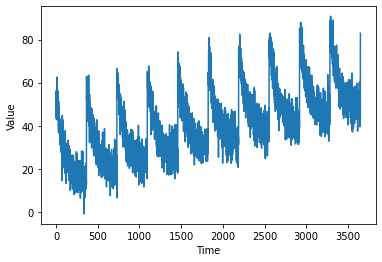

In [7]:
# Set the data series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

plot_series(time, series)

In [0]:
# Define the windowed_dataset function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Create dataset from series and pass the series to it
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # Window the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  # Mapping a dataset element to a (window_size + 1) batch size dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # Shuffle the dataset at the shuffle_buffer and split into features and labels
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  # Batch the select batch size
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [0]:
# Split dataset into training and validation sets
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [9]:
# Build the DNN model

# Set the constans that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Create the dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(
    loss="mse",
    optimizer=optimizer
)

history = model.fit(
    dataset,
    epochs=100,
    verbose=1
)

Epoch 1/100
94/94 [==============================] - 1s 6ms/step - loss: 298.4785
Epoch 2/100
94/94 [==============================] - 1s 5ms/step - loss: 92.4241
Epoch 3/100
94/94 [==============================] - 1s 5ms/step - loss: 69.2724
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 60.6547
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 56.5877
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 54.0867
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 52.0055
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 50.3846
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 48.9437
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss: 48.3104
Epoch 11/100
94/94 [==============================] - 1s 6ms/step - loss: 46.5548
Epoch 12/100
94/94 [==============================] - 1s 6ms/step - loss: 46.2653
Epoch 13/100
94/94 [====

In [0]:
# Forecast every time points of time series
forecast = []

# Iterate over the series and taking slice the window size and predict them
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Split results after the split time and load them into numpy array
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

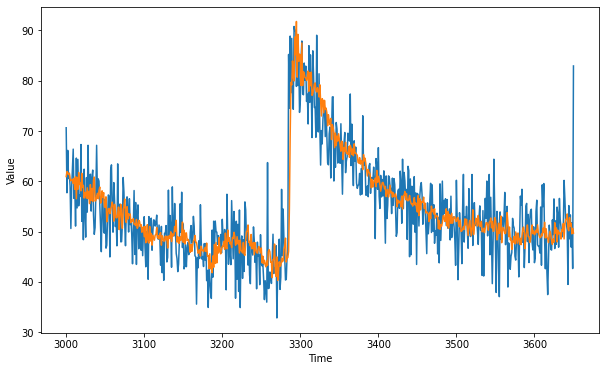

In [11]:
# Plot results
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# Actual -- Blue, Prediction -- Orange

In [12]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# mae = np.abs(errors).mean()

4.436628

In [13]:
# Build the DNN model with optimal learning rate

# Set the constans that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Create the dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Callback learning rate sheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(
    loss="mse",
    optimizer=optimizer
)

history = model.fit(
    dataset,
    epochs=100,
    verbose=1,
    callbacks=[lr_schedule]
)

Epoch 1/100
94/94 [==============================] - 1s 6ms/step - loss: 846.4724 - lr: 1.0000e-06
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 51.8986 - lr: 1.1220e-06
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 48.4969 - lr: 1.2589e-06
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 46.9401 - lr: 1.4125e-06
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 46.0863 - lr: 1.5849e-06
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 45.7638 - lr: 1.7783e-06
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 43.9415 - lr: 1.9953e-06
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 42.7648 - lr: 2.2387e-06
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 42.5564 - lr: 2.5119e-06
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss: 41.1332 - lr: 2.8184e-06
Epoch 11/100
94/94

(1e-08, 0.001, 0.0, 300.0)

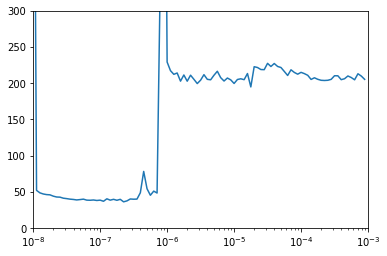

In [14]:
# Plot the loss/epoch
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

# y axis -- loss
# x axis -- learning rate
# Stable point -- 2e-6

In [15]:
# Retrain the DNN model with stable learning rate point

# Set the constans that pass to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Create the dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=2e-6, momentum=0.9)

model.compile(
    loss="mse",
    optimizer=optimizer
)

history = model.fit(
    dataset,
    epochs=500,
    verbose=1
)

Epoch 1/500
94/94 [==============================] - 1s 6ms/step - loss: 229.1770
Epoch 2/500
94/94 [==============================] - 1s 7ms/step - loss: 52.3909
Epoch 3/500
94/94 [==============================] - 1s 6ms/step - loss: 48.9272
Epoch 4/500
94/94 [==============================] - 1s 6ms/step - loss: 46.8401
Epoch 5/500
94/94 [==============================] - 1s 6ms/step - loss: 44.2762
Epoch 6/500
94/94 [==============================] - 1s 6ms/step - loss: 43.4058
Epoch 7/500
94/94 [==============================] - 1s 6ms/step - loss: 42.6124
Epoch 8/500
94/94 [==============================] - 1s 6ms/step - loss: 42.2282
Epoch 9/500
94/94 [==============================] - 1s 6ms/step - loss: 41.1836
Epoch 10/500
94/94 [==============================] - 1s 6ms/step - loss: 40.6985
Epoch 11/500
94/94 [==============================] - 1s 6ms/step - loss: 40.2661
Epoch 12/500
94/94 [==============================] - 1s 6ms/step - loss: 40.1749
Epoch 13/500
94/94 [====

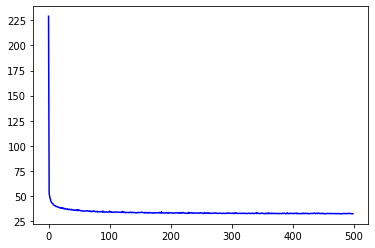

In [16]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[40.26606750488281, 40.1749153137207, 39.7425422668457, 39.1841926574707, 39.24214172363281, 39.18734359741211, 38.83989334106445, 38.29244613647461, 38.30413055419922, 38.109378814697266, 37.81071090698242, 38.38755416870117, 37.67620086669922, 38.087860107421875, 37.29075241088867, 37.59199523925781, 37.06793975830078, 37.355804443359375, 36.83671569824219, 36.80694580078125, 37.022403717041016, 37.10572814941406, 36.285865783691406, 36.49872589111328, 36.821022033691406, 36.36382293701172, 36.089561462402344, 36.56525802612305, 36.224178314208984, 36.27873611450195, 35.91999435424805, 35.631431579589844, 35.90146255493164, 35.794002532958984, 35.6321907043457, 35.95929718017578, 35.526771545410156, 36.06807327270508, 35.21808624267578, 36.09236145019531, 35.96647262573242, 35.654510498046875, 35.253150939941406, 35.266239166259766, 35.1052131652832, 35.04178237915039, 35.008697509765625, 34.78828430175781, 34.96297073364258, 34.89957809448242, 34.973915100097656, 34.99713134765625, 

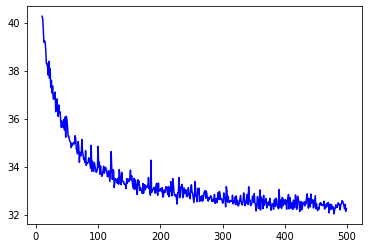

In [17]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [0]:
# Forecast every time points of time series
forecast = []

# Iterate over the series and taking slice the window size and predict them
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Split results after the split time and load them into numpy array
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

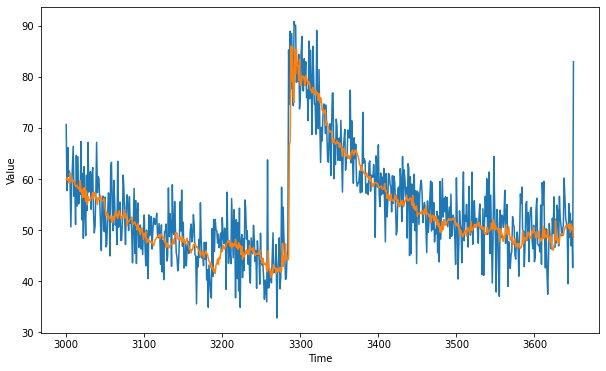

In [19]:
# Plot results
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# Actual -- Blue, Prediction -- Orange

In [20]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# mae = np.abs(errors).mean()
# Sgnificantly lower than earlier

4.4030986